# Experiment Parametrization

In [ ]:
exp_dir = './paper_results/'
exp_epoch_size = 2**16

## Imports

In [2]:
import math
import numpy as np
import pandas as pd

# MatPlotLib
import matplotlib.pylab as pylab
from matplotlib.patches import Rectangle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

%matplotlib inline

pylab.rcParams['font.size'] = 24
pylab.rcParams['figure.figsize'] = [3*x for x in [3.52, 2.64]]
pylab.rcParams['figure.dpi'] = 100
pylab.rcParams['errorbar.capsize'] = 3
pylab.rcParams['legend.fontsize'] = 16
pylab.rcParams['lines.linewidth'] = 2

gridcolor = '#bbbbbb'

zvalue = 2.576  # 99%

## Load data

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("mn", exp_dir + "/configure.py")
make_network = importlib.util.module_from_spec(spec)
spec.loader.exec_module(make_network)
exp_LBW = make_network.LBW
exp_Q_RATE = make_network.Q_RATE
exp_Q_DEPTH_FRAC = make_network.Q_DEPTH_FRAC
exp_CTH_DEPTH_FRAC = make_network.CTH_DEPTH_FRAC
exp_Q_DEPTH = make_network.Q_DEPTH
exp_CTH_DEPTH = make_network.CTH_DEPTH
exp_CTH_TIMEDELTA = make_network.CTH_TIMEDELTA

print('LBW:           ', exp_LBW, 'Mb/s')
print('Q_RATE:        ', exp_Q_RATE, 'Packets/Second')
print('Q_DEPTH:       ', exp_Q_DEPTH, 'Packets')
print('Q_DEPTH_FRAC:  ', exp_Q_DEPTH_FRAC)
print('CTH_DEPTH:     ', exp_CTH_DEPTH, 'Packets')
print('CTH_DEPTH_FRAC:', exp_CTH_DEPTH_FRAC)
print('CTH_TIMEDELTA: ', exp_CTH_TIMEDELTA, 'Microseconds')

LBW:            100 Mb/s
Q_RATE:         9000 Packets/Second
Q_DEPTH:        1125 Packets
Q_DEPTH_FRAC:   8
CTH_DEPTH:      140 Packets
CTH_DEPTH_FRAC: 8
CTH_TIMEDELTA:  15625 Microseconds


In [4]:
fns = []
flows = []
fns = ['s1-reports.csv', 's2-reports.csv', 's3-reports.csv', 's4-reports.csv', 's5-reports.csv', 's6-reports.csv', 's7-reports.csv']
flows = [
    {'id': 11, 'name': 'green', 'color': '#009900', 'psrc': 3, 'pdst': 5, 'path': 'C–E'},
    {'id': 5, 'name': 'teal', 'color': '#009999', 'psrc': 1, 'pdst': 5, 'path': 'B–E'},
    {'id': 26, 'name': 'orange', 'color': '#FF8000', 'psrc': 3, 'pdst': 7, 'path': 'C–G'},
    {'id': 3, 'name': 'red', 'color': '#CC0000', 'psrc': 1, 'pdst': 7, 'path': 'A–H'}
]

for fn in fns:
    tmp1 = pd.read_csv(exp_dir + '/logs/' + fn)
    tmp1['eepoch'] = tmp1['eepoch'] - tmp1['eepoch'].min() + 1 - math.floor(5e6/exp_epoch_size)
    
    for flow in flows:
        if 'reports' not in flow:
            flow['reports'] = pd.DataFrame()
        tmp2 = tmp1[(tmp1['flow'] == flow['id']) & (tmp1['psrc'] == flow['psrc']) & (tmp1['pdst'] == flow['pdst'])]
        flow['reports'] = pd.concat([flow['reports'], tmp2])

last_epoch = 0
for flow in flows:
    flow['label'] = '{} ({})'.format(flow['name'].title(), flow['path'])
    flow['reports']['epoch'] = flow['reports']['epoch'] \
                               - flow['reports']['epoch'].min() + 1 - math.floor(5e6/exp_epoch_size)
    last_epoch = max(last_epoch, flow['reports']['epoch'].max())
    flow['reports'] = flow['reports'][flow['reports']['epoch'] > 0]
    flow['reports']['ibits'] = flow['reports']['ibytes']*8
    flow['reports']['ebits'] = flow['reports']['ebytes']*8

last_epoch = math.ceil(60e6/exp_epoch_size)
print('last epoch:', last_epoch)

last epoch: 916


# Figures

## Upper part of Figure 6(b) – Provided bandwidth for the Red Traffic.

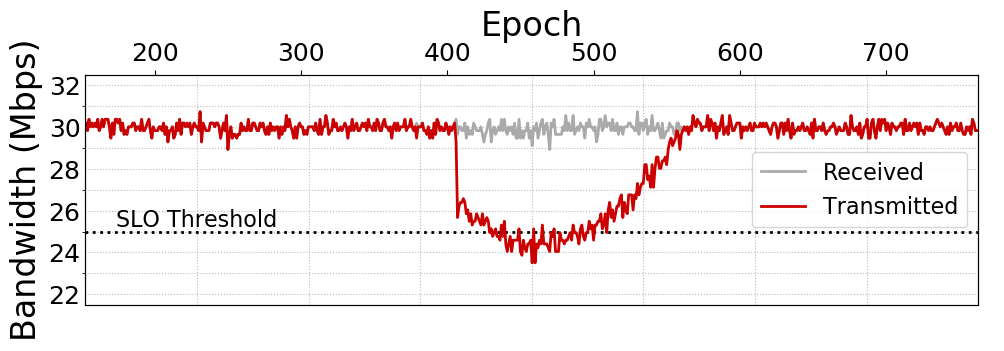

In [5]:
beg = 10
end = 50

show_acc = False
show_flows = ['red']
show_legend = True

fig = pylab.figure(figsize=[3*3.52, 1.5*2.64])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

yacum = None
xacum = None

for flow in flows:
    if flow['name'] not in show_flows:
        continue
    df = flow['reports']
    df = df[(df['epoch'] >= ((beg*1e6)/exp_epoch_size)) & (df['epoch'] <= ((end*1e6)/exp_epoch_size))]
    x = df['epoch']/(1e6/exp_epoch_size)

    y = df['ibits']*(1/exp_epoch_size)
    ax1.plot(x, y, label='Received', color='#AAAAAA', ls='-', lw=2)
    
    y = df['ebits']*(1/exp_epoch_size)
    ax1.plot(x, y, label='Transmitted', color=flow['color'], lw=2)
    
    if yacum is None:
        xacum = np.array(x)
        yacum = np.array(y)
    else:
        yacum = yacum + np.array(y)

if show_acc is True:
    ax1.plot(xacum, yacum, label='Accumulated', lw=1, c='k')
ax1.hlines(25, beg, end, lw=2, color='k', ls=':')
ax1.text(15, 25.25, 'SLO Threshold', size=16, horizontalalignment='center')

# ax1.set_xlabel('Experiment Second')
ax1.set_xlim(beg, end)
ax1.set_xticks(range(beg, end + 1, 5))
ax1.tick_params(length=0)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=18, color='w')

ax2.set_xlabel('Epoch')
ax2.set_xlim(((beg*1e6)/exp_epoch_size), ((end*1e6)/exp_epoch_size))
ax2.set_xticklabels([int(x) for x in ax2.get_xticks()], fontsize=18)

ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

ax1.set_ylabel('Bandwidth (Mbps)')
ax1.set_ylim(21.5, 32.5)
ax1.set_yticks(range(22, 32 + 1, 2))
ax1.set_yticklabels([int(x) for x in ax1.get_yticks()], fontsize=18)
ax1.yaxis.set_minor_locator(MultipleLocator(1))

if show_legend is True:
    ax1.legend(loc='center right')

pylab.tight_layout()
pylab.savefig(exp_dir + 'upperfig6b.pdf', transparent=True)


## Lower part of Figure 6(b) – Packet drops for the Red Traffic.

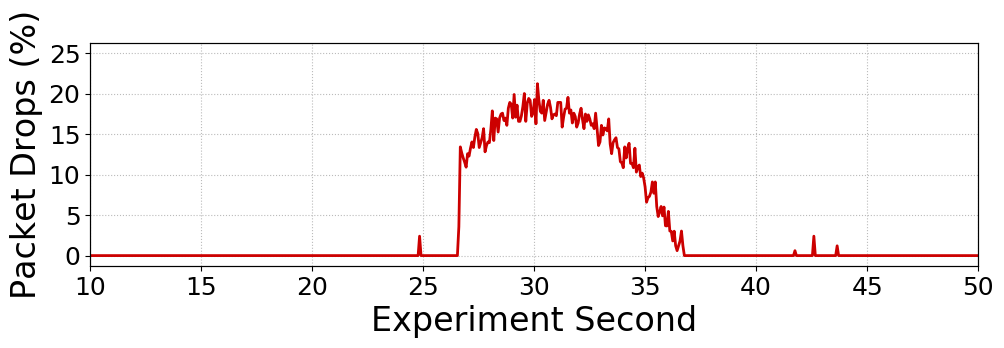

In [6]:
beg = 10
end = 50

show_acc = False
show_flows = ['red']
show_legend = False

fig = pylab.figure(figsize=[3*3.52, 1.5*2.64])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

yacum = None
xacum = None

for flow in flows:
    if flow['name'] not in show_flows:
        continue
    df = flow['reports']
    df = df[(df['epoch'] >= ((beg*1e6)/exp_epoch_size)) & (df['epoch'] <= ((end*1e6)/exp_epoch_size))]
    x = df['epoch']/(1e6/exp_epoch_size)
    y = df['drops']*100/df['ipkts']
    
    ax1.plot(x, y, label=flow['label'], color=flow['color'], lw=2)
    
    if yacum is None:
        xacum = np.array(x)
        yacum = np.array(y)
    else:
        yacum = yacum + np.array(y)

if show_acc is True:
    ax1.plot(xacum, yacum, label='Accumulated', lw=1, c='k')

ax1.set_xlabel('Experiment Second')
ax1.set_xlim(beg, end)
ax1.set_xticks(range(beg, end + 1, 5))
ax1.set_xticklabels(ax1.get_xticks(), fontsize=18)

# ax2.set_xlabel('Epoch')
ax2.set_xlim(((beg*1e6)/exp_epoch_size), ((end*1e6)/exp_epoch_size))
ax2.set_xticklabels([int(x) for x in ax2.get_xticks()], fontsize=18, color='w')
ax2.tick_params(length=0)

ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

ax1.set_ylabel('Packet Drops (%)')
ax1.set_ylim(-1.25, 26.25)
ax1.set_yticks(range(0, 25 + 1, 5))
ax1.set_yticklabels([int(x) for x in ax1.get_yticks()], fontsize=18)
ax1.yaxis.set_minor_locator(MultipleLocator(5))

if show_legend is True:
    ax1.legend(loc='center')

pylab.tight_layout()
pylab.savefig(exp_dir + 'lowerfig6b.pdf', transparent=True)


## Figure 6(c) – Arrival rate (in Mb/s) for traffic being forwarded by Node N3.

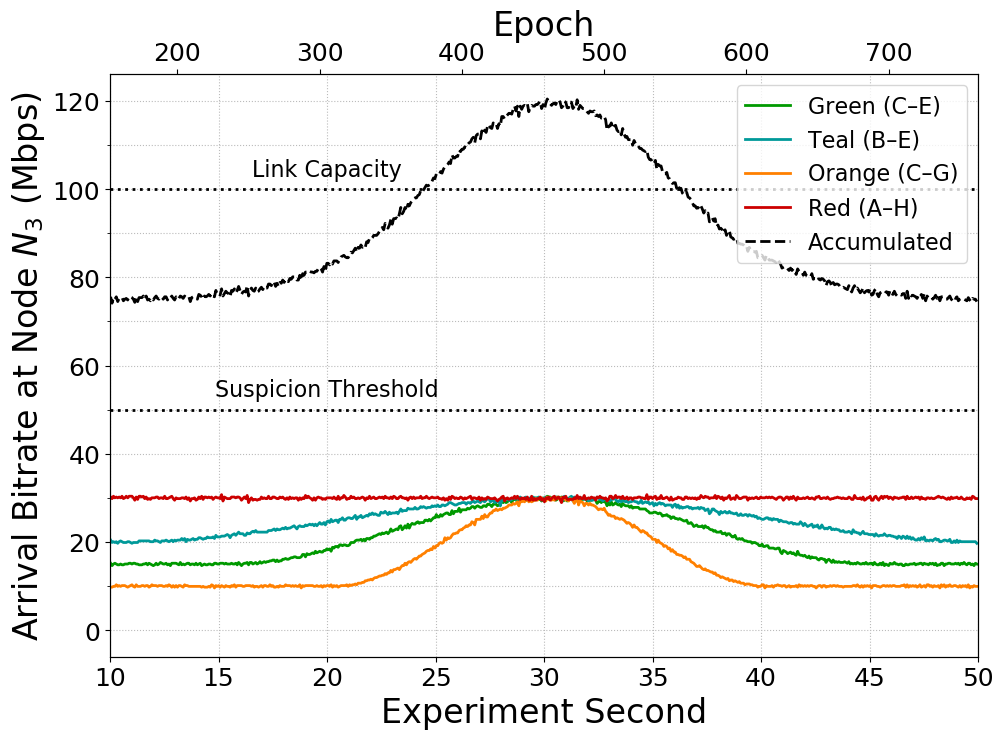

In [7]:
beg = 10
end = 50

fig = pylab.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

yacum = None
xacum = None

for flow in flows:
    df = flow['reports']
    df = df[(df['epoch'] >= ((beg*1e6)/exp_epoch_size)) & (df['epoch'] <= ((end*1e6)/exp_epoch_size))]
    x = df['epoch']/(1e6/exp_epoch_size)
    y = df['ibits']*(1/exp_epoch_size)
    
    ax1.plot(x, y, label=flow['label'], color=flow['color'], lw=2)
    
    if yacum is None:
        xacum = np.array(x)
        yacum = np.array(y)
    else:
        yacum = yacum + np.array(y)

ax1.plot(xacum, yacum, label='Accumulated', ls='--', lw=2, c='k')
ax1.hlines(100, beg, end, lw=2, color='k', ls=':')
ax1.text(beg + 10, 103, 'Link Capacity', size=16, horizontalalignment='center')
ax1.hlines(50, beg, end, lw=2, color='k', ls=':')
ax1.text(beg + 10, 53, 'Suspicion Threshold', size=16, horizontalalignment='center')

ax1.set_xlabel('Experiment Second')
ax1.set_xlim(beg, end)
ax1.set_xticks(range(beg, end + 1, 5))
ax1.set_xticklabels(ax1.get_xticks(), fontsize=18)

ax2.set_xlabel('Epoch')
ax2.set_xlim(((beg*1e6)/exp_epoch_size), ((end*1e6)/exp_epoch_size))
ax2.set_xticklabels([int(x) for x in ax2.get_xticks()], fontsize=18)

ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

ax1.set_ylabel('Arrival Bitrate at Node $N_{3}$ (Mbps)')
ax1.set_ylim(-6, 126)
ax1.set_yticks(range(0, 120 + 1, 20))
ax1.set_yticklabels([int(x) for x in ax1.get_yticks()], fontsize=18)
ax1.yaxis.set_minor_locator(MultipleLocator(10))

ax1.legend(loc='upper right')

pylab.tight_layout()
pylab.savefig(exp_dir + 'fig6c.pdf', transparent=True)


# Extra Figures

## Reports

### Reporting Reasons

In [8]:
for f in flows:
    reps = f['reports']
    
    reps = reps[(reps['epoch'] >= 305) & (reps['epoch'] <= 625)]
    print('#', f['name'].title())
    flg = True
    slic = reps[(reps['cps'].apply(lambda x: ('^' in x) or ('c' in x)))]
    if len(slic):
        print('Contention ({})'.format(len(slic)))
        flg = False
        display(slic)
        
    slic = reps[(reps['sps'].apply(lambda x: ('s' in x)))]
    if len(slic):
        print('Suspicion ({})'.format(len(slic)))
        flg = False
        display(slic)

    slic = reps[(reps['hds'] > 0)]
    if len(slic):
        print('High Delayed Packets ({})'.format(len(slic)))
        flg = False
        display(slic)
        
    slic = reps[(reps['drops'] > 0)]
    if len(slic):
        print('Drops ({})'.format(len(slic)))
        flg = False
        display(slic)
    
    if f['name'] == 'red':
        BW_SLA = (25e6/8)*(2**16/1e6)  # 25 Mbps SLA
        slic = reps[(reps['ebytes'] < BW_SLA) & (reps['drops'] > 0)]
        if len(slic):
            print('Low Goodput ({})'.format(len(slic)))
            flg = False
            display(slic)
        
    if flg:
        print('    nothing to display\n')

# Green
Contention (210)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
783,386,388,11,3,5,0,2,c-,--,0,143,143,0,211783,211783,1694264,1694264
785,387,389,11,3,5,0,2,c-,--,0,145,145,0,214745,214745,1717960,1717960
787,388,390,11,3,5,0,2,c-,--,0,146,146,0,216226,216226,1729808,1729808
789,389,391,11,3,5,0,2,c-,--,0,147,147,0,217707,217707,1741656,1741656
791,390,392,11,3,5,0,2,c-,--,0,147,147,0,217707,217707,1741656,1741656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,591,593,11,3,5,0,2,c-,--,0,117,117,0,173277,173277,1386216,1386216
1195,592,594,11,3,5,0,2,c-,--,0,119,119,0,176239,176239,1409912,1409912
1197,593,595,11,3,5,0,2,c-,--,0,115,115,0,170315,170315,1362520,1362520
1199,594,596,11,3,5,0,2,c-,--,0,114,114,0,168834,168834,1350672,1350672


Drops (154)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
821,405,409,11,3,5,0,2,c-,--,0,152,145,7,225112,214745,1800896,1717960
823,406,410,11,3,5,0,2,c-,--,0,153,133,20,226593,196973,1812744,1575784
825,407,411,11,3,5,0,2,c-,--,0,155,140,15,229555,207340,1836440,1658720
827,408,412,11,3,5,0,2,c-,--,0,155,134,21,229555,198454,1836440,1587632
829,409,413,11,3,5,0,2,c-,--,0,153,134,19,226593,198454,1812744,1587632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,554,558,11,3,5,0,2,c-,--,0,139,136,3,205859,201416,1646872,1611328
1121,555,559,11,3,5,0,2,c-,--,0,138,135,3,204378,199935,1635024,1599480
1123,556,560,11,3,5,0,2,c-,--,0,137,136,1,202897,201416,1623176,1611328
1125,557,561,11,3,5,0,2,c-,--,0,137,135,2,202897,199935,1623176,1599480


# Teal
Contention (210)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
782,387,388,5,1,5,0,3,-c-,---,0,157,157,0,232517,232517,1860136,1860136
784,388,389,5,1,5,0,3,-c-,---,0,156,156,0,231036,231036,1848288,1848288
786,389,390,5,1,5,0,3,-c-,---,0,157,157,0,232517,232517,1860136,1860136
788,390,391,5,1,5,0,3,-c-,---,0,158,158,0,233998,233998,1871984,1871984
790,391,392,5,1,5,0,3,-c-,---,0,160,160,0,236960,236960,1895680,1895680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,592,593,5,1,5,0,3,-c-,---,0,146,146,0,216226,216226,1729808,1729808
1194,593,594,5,1,5,0,3,-c-,---,0,147,147,0,217707,217707,1741656,1741656
1196,594,595,5,1,5,0,3,-c-,---,0,144,144,0,213264,213264,1706112,1706112
1198,595,596,5,1,5,0,3,-c-,---,0,144,144,0,213264,213264,1706112,1706112


Drops (155)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
766,379,380,5,1,5,0,3,---,---,0,156,152,4,231036,225112,1848288,1800896
820,406,409,5,1,5,0,3,-c-,---,0,159,151,8,235479,223631,1883832,1789048
822,407,410,5,1,5,0,3,-c-,---,0,161,148,13,238441,219188,1907528,1753504
824,408,411,5,1,5,0,3,-c-,---,0,162,143,19,239922,211783,1919376,1694264
826,409,412,5,1,5,0,3,-c-,---,0,160,141,19,236960,208821,1895680,1670568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,555,558,5,1,5,0,3,-c-,---,0,153,149,4,226593,220669,1812744,1765352
1120,556,559,5,1,5,0,3,-c-,---,0,154,151,3,228074,223631,1824592,1789048
1122,557,560,5,1,5,0,3,-c-,---,0,154,151,3,228074,223631,1824592,1789048
1124,558,561,5,1,5,0,3,-c-,---,0,155,153,2,229555,226593,1836440,1812744


# Orange
Contention (210)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
784,385,388,26,3,7,0,3,c--,---,0,110,110,0,162910,162910,1303280,1303280
786,386,389,26,3,7,0,3,c--,---,0,109,109,0,161429,161429,1291432,1291432
788,387,390,26,3,7,0,3,c--,---,0,110,110,0,162910,162910,1303280,1303280
790,388,391,26,3,7,0,3,c--,---,0,116,116,0,171796,171796,1374368,1374368
792,389,392,26,3,7,0,3,c--,---,0,113,113,0,167353,167353,1338824,1338824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,590,593,26,3,7,0,3,c--,---,0,63,63,0,93303,93303,746424,746424
1196,591,594,26,3,7,0,3,c--,---,0,61,61,0,90341,90341,722728,722728
1198,592,595,26,3,7,0,3,c--,---,0,62,62,0,91822,91822,734576,734576
1200,593,596,26,3,7,0,3,c--,---,0,61,61,0,90341,90341,722728,722728


Drops (154)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
822,404,409,26,3,7,0,3,c--,---,0,130,124,6,192530,183644,1540240,1469152
824,405,410,26,3,7,0,3,c--,---,0,132,115,17,195492,170315,1563936,1362520
826,406,411,26,3,7,0,3,c--,---,0,132,115,17,195492,170315,1563936,1362520
828,407,412,26,3,7,0,3,c--,---,0,136,120,16,201416,177720,1611328,1421760
830,408,413,26,3,7,0,3,c--,---,0,135,119,16,199935,176239,1599480,1409912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,554,559,26,3,7,0,3,c--,---,0,94,92,2,139214,136252,1113712,1090016
1124,555,560,26,3,7,0,3,c--,---,0,93,89,4,137733,131809,1101864,1054472
1126,556,561,26,3,7,0,3,c--,---,0,91,89,2,134771,131809,1078168,1054472
1128,557,562,26,3,7,0,3,c--,---,0,92,91,1,136252,134771,1090016,1078168


# Red
Contention (210)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
783,387,388,3,1,7,0,4,-c--,----,0,166,166,0,245846,245846,1966768,1966768
785,388,389,3,1,7,0,4,-c--,----,0,163,163,0,241403,241403,1931224,1931224
787,389,390,3,1,7,0,4,-c--,----,0,165,165,0,244365,244365,1954920,1954920
789,390,391,3,1,7,0,4,-c--,----,0,163,163,0,241403,241403,1931224,1931224
791,391,392,3,1,7,0,4,-c--,----,0,167,167,0,247327,247327,1978616,1978616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,592,593,3,1,7,0,4,-c--,----,0,164,164,0,242884,242884,1943072,1943072
1195,593,594,3,1,7,0,4,-c--,----,0,169,169,0,250289,250289,2002312,2002312
1197,594,595,3,1,7,0,4,-c--,----,0,167,167,0,247327,247327,1978616,1978616
1199,595,596,3,1,7,0,4,-c--,----,0,165,165,0,244365,244365,1954920,1954920


Drops (156)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
767,379,379,3,1,7,0,4,----,----,0,167,163,4,247327,241403,1978616,1931224
821,406,409,3,1,7,0,4,-c--,----,0,168,162,6,248808,239922,1990464,1919376
823,407,410,3,1,7,0,4,-c--,----,0,164,142,22,242884,210302,1943072,1682416
825,408,411,3,1,7,0,4,-c--,----,0,166,145,21,245846,214745,1966768,1717960
827,409,412,3,1,7,0,4,-c--,----,0,166,146,20,245846,216226,1966768,1729808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,556,559,3,1,7,0,4,-c--,----,0,164,163,1,242884,241403,1943072,1931224
1123,557,560,3,1,7,0,4,-c--,----,0,167,165,2,247327,244365,1978616,1954920
1125,558,561,3,1,7,0,4,-c--,----,0,167,164,3,247327,242884,1978616,1943072
1127,559,562,3,1,7,0,4,-c--,----,0,165,160,5,244365,236960,1954920,1895680


Low Goodput (59)


,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
867,429,432,3,1,7,0,4,-c--,----,0,168,138,30,248808,204378,1990464,1635024
871,431,434,3,1,7,0,4,-c--,----,0,165,137,28,244365,202897,1954920,1623176
873,432,435,3,1,7,0,4,-c--,----,0,166,138,28,245846,204378,1966768,1635024
877,434,437,3,1,7,0,4,-c--,----,0,165,137,28,244365,202897,1954920,1623176
879,435,438,3,1,7,0,4,-c--,----,0,166,137,29,245846,202897,1966768,1623176
881,436,439,3,1,7,0,4,-c--,----,0,165,136,29,244365,201416,1954920,1611328
885,438,441,3,1,7,0,4,-c--,----,0,165,137,28,244365,202897,1954920,1623176
889,440,443,3,1,7,0,4,-c--,----,0,165,135,30,244365,199935,1954920,1599480
891,441,444,3,1,7,0,4,-c--,----,0,164,133,31,242884,196973,1943072,1575784
893,442,445,3,1,7,0,4,-c--,----,0,166,135,31,245846,199935,1966768,1599480


### Raw Reports

In [9]:
raw_reports = None

for f in flows:
    reps = f['reports']
    reps['flow'] =  [f['name'].title()]*len(reps)

    if f['name'] != 'red':
        slic = reps[(reps['cps'].apply(lambda x: ('^' in x) or ('c' in x)))
                    | (reps['sps'].apply(lambda x: ('s' in x)))
                    | (reps['hds'] > 0)
                    | (reps['drops'] > 0)]
    else:
        BW_SLA = (25e6/8)*(2**16/1e6)  # 25 Mbps SLA
        slic = reps[(reps['cps'].apply(lambda x: ('^' in x) or ('c' in x)))
                    | (reps['sps'].apply(lambda x: ('s' in x)))
                    | (reps['hds'] > 0)
                    | (reps['drops'] > 0)
                    | ((reps['ebytes'] < BW_SLA) & (reps['drops'] > 0))]
    
    
    if raw_reports is None:
        raw_reports = slic
    else:
        raw_reports = pd.concat([raw_reports, slic])
        
display(raw_reports)

,epoch,eepoch,flow,psrc,pdst,path,plen,cps,sps,hds,ipkts,epkts,drops,ibytes,ebytes,ibits,ebits
783,386,388,Green,3,5,0,2,c-,--,0,143,143,0,211783,211783,1694264,1694264
785,387,389,Green,3,5,0,2,c-,--,0,145,145,0,214745,214745,1717960,1717960
787,388,390,Green,3,5,0,2,c-,--,0,146,146,0,216226,216226,1729808,1729808
789,389,391,Green,3,5,0,2,c-,--,0,147,147,0,217707,217707,1741656,1741656
791,390,392,Green,3,5,0,2,c-,--,0,147,147,0,217707,217707,1741656,1741656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,637,637,Red,1,7,0,4,----,----,0,165,164,1,244365,242884,1954920,1943072
1309,650,650,Red,1,7,0,4,----,----,0,167,163,4,247327,241403,1978616,1931224
1341,666,666,Red,1,7,0,4,----,----,0,166,164,2,245846,242884,1966768,1943072
1615,803,803,Red,1,7,0,4,----,----,0,167,162,5,247327,239922,1978616,1919376
